# Synthetic Control: USA cities traffic

In this notebook we showcase the use of Bayesian synthetic control for analysis a test.

In [1]:
%load_ext autoreload
%autoreload 2

# set-up
import sys, os 
from dotenv import load_dotenv
load_dotenv("../.env")
sys.path.append(os.environ.get("SRC_FOLDER"))

In [2]:
from causalinf.ab.synthetic_control.bayesian.models import GLM
import causalinf.ab.synthetic_control.bayesian.inference

import plotly.subplots
import matplotlib.pyplot as plt
import arviz as az 
import os
import pymc as pm 
import pandas as pd 

# for experimenting
import numpy as np 
import scipy.stats as stats

# Parameters 
random_seed = 9374

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



# Data Explotation

In [3]:
df = pd.read_csv(os.path.join(os.environ.get("SRC_FOLDER"), "tests/fixtures/ga-visits-usa-cities.csv"))
df = causalinf.libs.pd_tools.format_dataframe( df, columns_datetime = ["period_start_date"])
df.head(3)

# Define treated and control units
treated_unit = "Houston"
control_units = [cc for cc in df.columns if cc not in [treated_unit, "period_start_date", "test_active"]]
step_intervention =  df[df["test_active"]==1].index.min()

# split data: pre/post test
# df = df.set_index("period_start_date")
mask_pre = df["test_active"]==0
df_pre, df_post = df.loc[mask_pre,[treated_unit]+control_units], df.loc[~mask_pre,[treated_unit]+control_units]


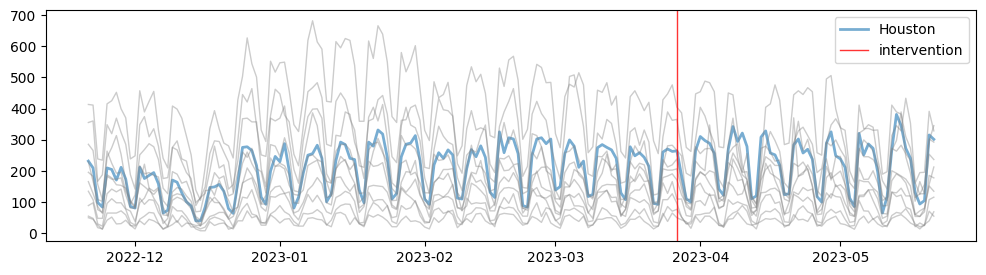

In [4]:
fig = plt.figure(figsize=(12.,3.))
Ax = fig.subplots(1,1,squeeze=False)
ax = Ax[0,0]
causalinf.plot.main.plot_units(df, treated_unit, control_units, step_intervention, col_time="period_start_date",  plot_args={"ax": ax}, backend="matplotlib" )
ax.legend()
plt.show()

## Fit Synthetic Control Model

In [5]:
dX_pre, dy_pre = df_pre[control_units], df_pre[[treated_unit]]
dX_post, dy_post = df_post[control_units], df_post[[treated_unit]]

In [6]:
model_params = dict(
    fit_intercept=False,
    positive_coefficients=True,
    n_chains = 2,
    n_draws = 200
)
sc = GLM( **model_params)
sc.fit(dX_pre, dy_pre)

print(f"Fit stats:\n"+sc._fit_stats.__str__())

/home/user/libs/dst-python-causal-inference/causalinf/ab/synthetic_control/bayesian/models.py:82: FutureWarning: The `testval` argument is deprecated; use `initval`.
  y_pred_std = pm.HalfCauchy(self._var_name_mean_std, beta=self._infinity_value_prior, testval=1.0)
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [coefs, y_pred_std]


Sampling 2 chains for 1_000 tune and 200 draw iterations (2_000 + 400 draws total) took 31 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Fit stats:
error_mean: 1.219
error_std: 28.113
r2: 0.864
mse: 778.963
rmse: 27.91



In [7]:
sc._coef_stats = sc._coef_stats.sort_values(by="mean", ascending=True)
display(sc._coef_stats)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Los Angeles,0.016,0.016,0.000,0.048,0.001,0.000,322.0,183.0,1.01
Atlanta,0.031,0.024,0.000,0.075,0.001,0.001,299.0,178.0,1.00
Dallas,0.044,0.031,0.000,0.097,0.001,0.001,429.0,195.0,1.00
Miami,0.052,0.047,0.000,0.143,0.002,0.001,259.0,79.0,1.01
Las Vegas,0.079,0.071,0.000,0.211,0.004,0.003,221.0,91.0,1.00
Boston,0.087,0.068,0.001,0.212,0.003,0.002,321.0,237.0,1.00
Phoenix,0.157,0.078,0.016,0.283,0.003,0.003,474.0,366.0,1.04
Austin,0.357,0.158,0.046,0.610,0.013,0.010,120.0,218.0,1.03
New Orleans,0.731,0.245,0.237,1.154,0.012,0.009,393.0,285.0,1.00
San Antonio,0.988,0.239,0.491,1.369,0.014,0.010,309.0,170.0,1.00


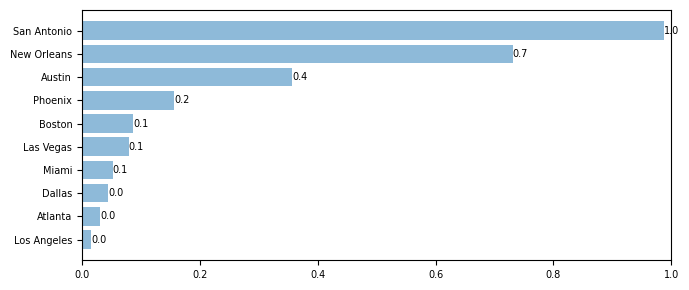

In [8]:
fig = plt.figure(figsize=(7.,3.))
Ax = fig.subplots(1,1,squeeze=False)
ax = Ax[0,0]
causalinf.plot.main.plot_coefficients(sc, add_value=True, text_format=".1f", ax=ax)
ax.tick_params(axis='y', labelsize=7)
ax.tick_params(axis='x', labelsize=7)
ax.set_xlim(0, 1)
fig.tight_layout()

## Inference

In [9]:
inference_model = causalinf.ab.synthetic_control.core.inference.InferenceModel(
    df_pre, df_post, sc, treated_unit, control_units, confidence_level=0.95
)
inference_model.compute()
inference_model.run_t_test()
_ = inference_model.get_summary_data()


Sampling: []


Sampling: []


In [10]:
inference_model.print_summary()


Below we look for (significant) differences between the mean of: actual and prediction .
The confidence intervals refer to the mean statistic. If they don't overlap, the mean of the two 
groups is likely to be significantly different.

                                        Average                                 Cumulative
actual (s.d.)                           226.86 (11.46)                          12704.0 (641.77)
CI (95.0%)                              [203.89, 249.82]                        [11417.86, 13990.14]

prediction (s.d.)                       190.61 (8.82)                           10674.32 (493.76)
CI (95.0%)                              [172.94, 208.28]                        [9684.79, 11663.84]

Absolute effect (s.d.)                  36.24 (8.82)                            2029.68 (493.76)
CI (95.0%)                              [18.57, 53.91]                          [1040.16, 3019.21]

Relative effect (s.d.)                  19.01% (4.63%)                       

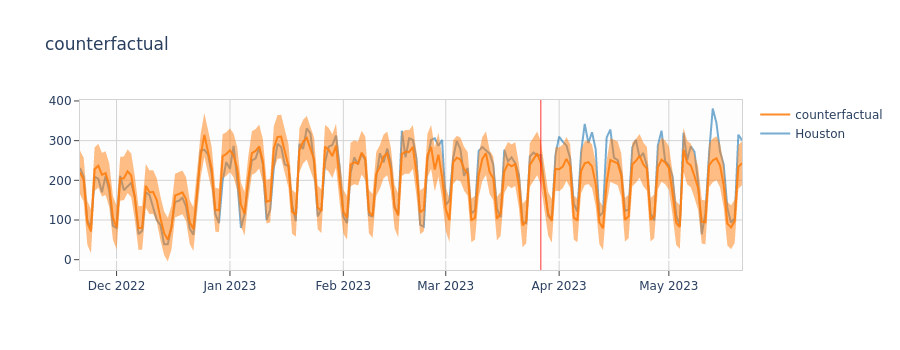

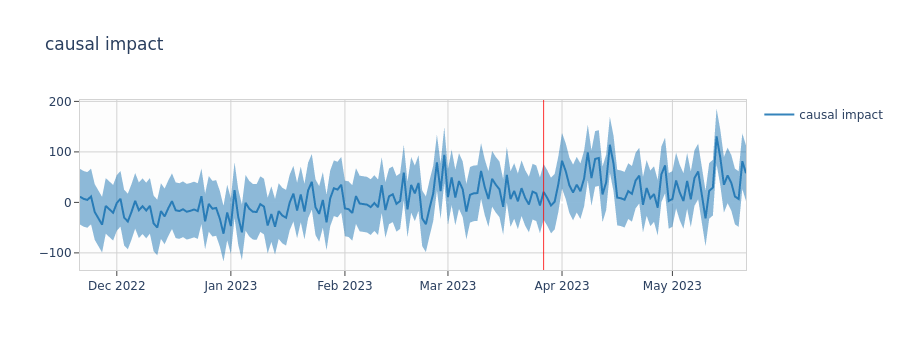

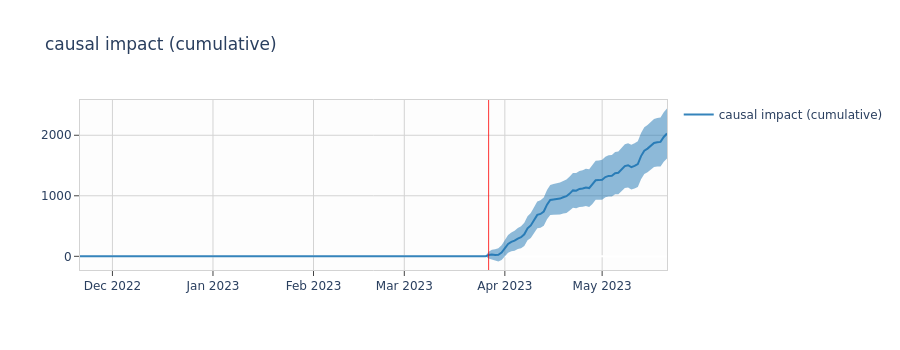

In [11]:
### Matplotlib backend 
# fig, Ax = causalinf.plot.main.plot_study(
#      df, treated_unit, inference_model.counterfactual, inference_model.causal_impact, 
#      inference_model.causal_impact_cum, step_intervention, figsize=(12.,9.),
#      col_time="period_start_date"
# )

### Plotly backend (requires import of `plotly.subplots`)
figs = causalinf.plot.main.plot_study(
     df, treated_unit, inference_model.counterfactual, inference_model.causal_impact, 
     inference_model.causal_impact_cum, step_intervention, backend="plotly", figsize=(900,350),
     col_time="period_start_date"
)
# for interactive figures - commented out as they won't render in github
# for _f in figs:
#     _f.show()
# for static render (as "png", "svg"; see plotly.io.renderers for all available options)
for _f in figs:
    _f.show("png")

# # You can save figures from this notebook, or programmatically, as below:
# fig.write_image( os.path.join( figs_path, "demo-backend-plotly.png"))
# fig.write_image( os.path.join( figs_path, "demo-backend-plotly.pdf"))

# # You can also export figures as html, e.g. for sharing with/presentig to clients
# fig.write_html( os.path.join( figs_path, "demo-backend-plotly.html"))

## Inference - Alternative Method 1

This second approach follows [Doudchenko and Imbens (2017)](https://arxiv.org/pdf/1610.07748.pdf). For each control unit we fit a synthetic control using the remaining units - including the treated unit. For each, we compute the ratio between a fit metric, $R$ (typicaly the mean square error, MSE, or root mean square error, RMSE) in the post and the pre period:
$$
\Phi_j = \frac{{R}_{post, j}}{{R}_{pre, j}}
$$
where $i$ is the control units. Typically, $\Phi_i>1$, as the fit of the synthetic control worsen when this is tried on unseen data. However, if the test campaign is having an impact (be this positive or negative), it is expect the fit to worsen even more. Namely, being $i$ the subscript associated to the treated unit, it is likely to have $\Phi_i > \Phi_j$ ($i\neq j$) if the treatment (campaign) is having a significant impact.

For each unit $j$, a $p$ value is computed as:
$$
p_j = \frac{N_{H,j}}{N}
$$
where $N$ is the total number of units (including the treated unit) and $N_{H,j}$ is the number of units with $\Phi_k>\Phi_j$. The campaign is expected to have had a significant impact when $p_j \ll 1$.

**Note**: this approach does not provide a high granularity when a low number of control units is used. Also, it is recommended to excude from the analysis:
1. control units who do not have a high contribution to the synthetic control of the treated unit. 
1. control units whose fit, in the pre-period, is considerably worse than the other units. If the fit is very bad ($R_{pre} \gg 1$), in fact, it is reasonable to observe a $R_{post}$ comparable to $R_{pre}$, which may fake the experiment.

In [12]:
# Fit a synthetic control for all control units.
# - Each control unit is sequentially considered as a treated unit.
# - We use the same model class and parameters used above.
inference_models = causalinf.ab.synthetic_control.core.inference.fit_predict_all(
    df_pre, df_post, 
    GLM, model_params    
)

/home/user/libs/dst-python-causal-inference/causalinf/ab/synthetic_control/bayesian/models.py:82: FutureWarning:

The `testval` argument is deprecated; use `initval`.

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [coefs, y_pred_std]


Sampling 2 chains for 1_000 tune and 200 draw iterations (2_000 + 400 draws total) took 32 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: []


Sampling: []


/home/user/libs/dst-python-causal-inference/causalinf/ab/synthetic_control/bayesian/models.py:82: FutureWarning:

The `testval` argument is deprecated; use `initval`.

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [coefs, y_pred_std]


Sampling 2 chains for 1_000 tune and 200 draw iterations (2_000 + 400 draws total) took 48 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: []


Sampling: []


/home/user/libs/dst-python-causal-inference/causalinf/ab/synthetic_control/bayesian/models.py:82: FutureWarning:

The `testval` argument is deprecated; use `initval`.

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [coefs, y_pred_std]


Sampling 2 chains for 1_000 tune and 200 draw iterations (2_000 + 400 draws total) took 32 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: []


Sampling: []


/home/user/libs/dst-python-causal-inference/causalinf/ab/synthetic_control/bayesian/models.py:82: FutureWarning:

The `testval` argument is deprecated; use `initval`.

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [coefs, y_pred_std]


Sampling 2 chains for 1_000 tune and 200 draw iterations (2_000 + 400 draws total) took 28 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: []


Sampling: []


/home/user/libs/dst-python-causal-inference/causalinf/ab/synthetic_control/bayesian/models.py:82: FutureWarning:

The `testval` argument is deprecated; use `initval`.

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [coefs, y_pred_std]


Sampling 2 chains for 1_000 tune and 200 draw iterations (2_000 + 400 draws total) took 27 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: []


Sampling: []


/home/user/libs/dst-python-causal-inference/causalinf/ab/synthetic_control/bayesian/models.py:82: FutureWarning:

The `testval` argument is deprecated; use `initval`.

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [coefs, y_pred_std]


Sampling 2 chains for 1_000 tune and 200 draw iterations (2_000 + 400 draws total) took 33 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: []


Sampling: []


/home/user/libs/dst-python-causal-inference/causalinf/ab/synthetic_control/bayesian/models.py:82: FutureWarning:

The `testval` argument is deprecated; use `initval`.

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [coefs, y_pred_std]


Sampling 2 chains for 1_000 tune and 200 draw iterations (2_000 + 400 draws total) took 34 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: []


Sampling: []


/home/user/libs/dst-python-causal-inference/causalinf/ab/synthetic_control/bayesian/models.py:82: FutureWarning:

The `testval` argument is deprecated; use `initval`.

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [coefs, y_pred_std]


Sampling 2 chains for 1_000 tune and 200 draw iterations (2_000 + 400 draws total) took 36 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: []


Sampling: []


/home/user/libs/dst-python-causal-inference/causalinf/ab/synthetic_control/bayesian/models.py:82: FutureWarning:

The `testval` argument is deprecated; use `initval`.

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [coefs, y_pred_std]


Sampling 2 chains for 1_000 tune and 200 draw iterations (2_000 + 400 draws total) took 37 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: []


Sampling: []


/home/user/libs/dst-python-causal-inference/causalinf/ab/synthetic_control/bayesian/models.py:82: FutureWarning:

The `testval` argument is deprecated; use `initval`.

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [coefs, y_pred_std]


Sampling 2 chains for 1_000 tune and 200 draw iterations (2_000 + 400 draws total) took 36 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: []


Sampling: []


/home/user/libs/dst-python-causal-inference/causalinf/ab/synthetic_control/bayesian/models.py:82: FutureWarning:

The `testval` argument is deprecated; use `initval`.

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [coefs, y_pred_std]


Sampling 2 chains for 1_000 tune and 200 draw iterations (2_000 + 400 draws total) took 38 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: []


Sampling: []


In [13]:
df_p_values = causalinf.ab.synthetic_control.core.inference.from_scores_to_p_values( 
    { unit: im for unit,im in inference_models.items() },
    kpi = "rmse_norm",
    treated_unit = treated_unit,
    coef_limit = 1e-4,
    remove_n_worse_scores = 0
    )
df_p_values

,kpi,pre,post,ratio_pre_post,p_value
Atlanta,rmse_norm,0.110062,0.282433,2.566136,0.000000
Miami,rmse_norm,0.113600,0.237258,2.088537,0.090909
Dallas,rmse_norm,0.120278,0.197626,1.643079,0.181818
Houston,rmse_norm,0.141278,0.217753,1.541312,0.272727
Las Vegas,rmse_norm,0.126019,0.165497,1.313275,0.363636
Boston,rmse_norm,0.132212,0.171240,1.295191,0.454545
San Antonio,rmse_norm,0.179120,0.224320,1.252346,0.545455
Los Angeles,rmse_norm,0.137437,0.158039,1.149902,0.636364
Austin,rmse_norm,0.171888,0.180875,1.052283,0.727273
Phoenix,rmse_norm,0.123954,0.129869,1.047719,0.818182


## Inference - Alternative Method 3

This third approach is similar to the one presented before. For each unit $j$, we look at the (normalised) cumulative causal impact over the post period, $C_j$. We then sort the $C_j$ coefficients and, for each unit $j$ we compute the p-values:
$$
p_{L,j} = \frac{N_{L,j}}{N}
$$
and
$$
p_{H,j} = \frac{N_{H,j}}{N}
$$

where:
- $N$ is the total number of units (including the treated unit);
- $N_{H,j}$ is the number of units with $\Phi_k>\Phi_j$; and
- $N_{L,j}$ is the number of units with $\Phi_k<\Phi_j$.

The campaign is expected to have had a significant impact when either $p_{L,j} \ll 1$ or $p_{H,j} \ll 1$. In particular:
- when $p_{H,j} \ll 1$, the campaign is likely to have caused a downlift.
- when $p_{L,j} \ll 1$, the campaign is likely to have cause an uplift.

In order to provide better granularity, bootstrapping is used to compute $C_j$ over multiple sub-sample of the post period. This strategy was also  suggested by [Doudchenko and Imbens (2017)](https://arxiv.org/pdf/1610.07748.pdf), who applied it to the calculation of the $\Phi_j$ ratios introduced in the previous section. 



In [14]:
df_p_values = causalinf.ab.synthetic_control.core.inference.from_causal_impacts_to_p_values(
    # {unit: im.causal_impact for unit,im in inference_models.items()},
    {unit: im for unit,im in inference_models.items()},
    treated_unit = None,
    resample = True, 
    sample_fraction = 0.9,
    n_repeat = 100,
    replace = True, 
    random_state = None
    ) 
df_p_values

,p_value_lower,p_value_higher,avg_cum_impact_norm
Houston,0.00130,0.99870,9.278169
Dallas,0.80009,0.19991,-3.565862
Austin,0.57494,0.42506,-1.188721
San Antonio,0.80118,0.19882,-3.671823
New Orleans,0.37206,0.62794,0.968693
Los Angeles,0.77469,0.22531,-3.266623
Atlanta,0.99318,0.00682,-6.831267
Phoenix,0.48097,0.51903,-0.244553
Miami,0.10900,0.89100,5.301974
Las Vegas,0.23291,0.76709,2.521060


# Alternative Visualisation
Below, we show the causal impact of the treated unit against those of all other units.

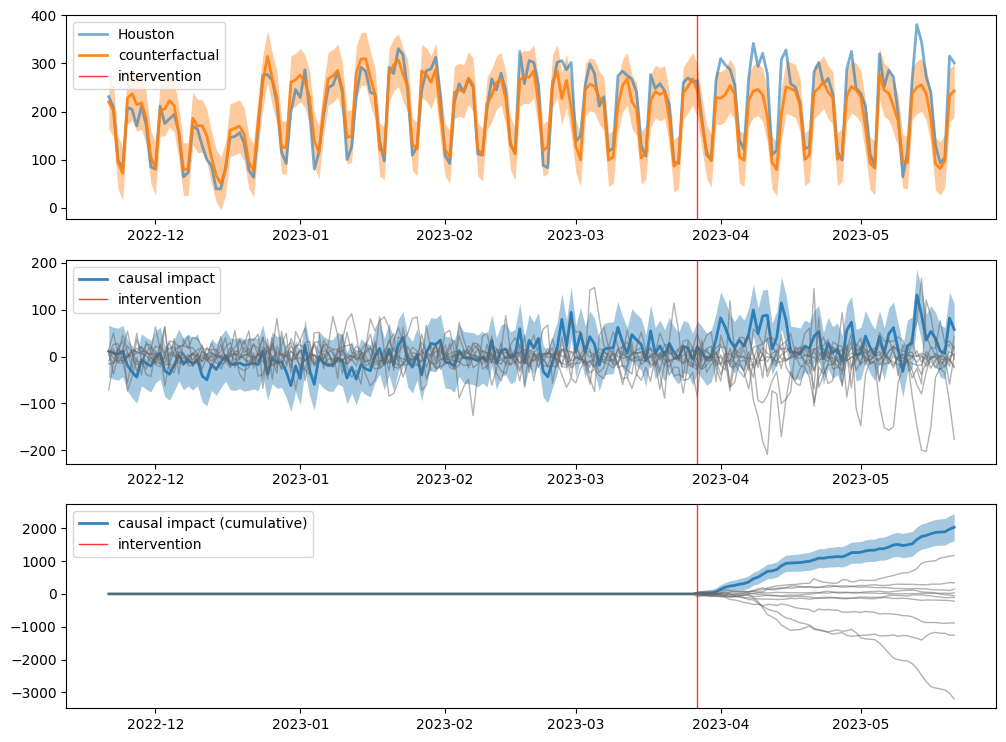

In [15]:
fig, Ax = causalinf.plot.main.plot_study(
     df, treated_unit, inference_model.counterfactual, inference_model.causal_impact, 
     inference_model.causal_impact_cum, step_intervention, figsize=(12.,9.),
     col_time="period_start_date"
)
_kwargs_ctrl_units = dict(lw=1, ls="-", alpha=.5, color="0.4")

ax = Ax[1,0]
for col in control_units:
    ax.plot(
        df["period_start_date"],
        inference_models[col].causal_impact["mean"]["full"], 
        **_kwargs_ctrl_units
    )
ax = Ax[2,0]
for col in control_units:
    ax.plot(
        df["period_start_date"],
        inference_models[col].causal_impact_cum["mean"]["full"], 
        **_kwargs_ctrl_units
    )
